In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import display,clear_output
#from warnings import filterwarnings
import cv2

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []

image_size = 150
for i in labels:
    folderPath = os.path.join('/home/zabtahi6294/Mycode/deep/Data/Cancer','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/home/zabtahi6294/Mycode/deep/Data/Cancer','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 266.97it/s]


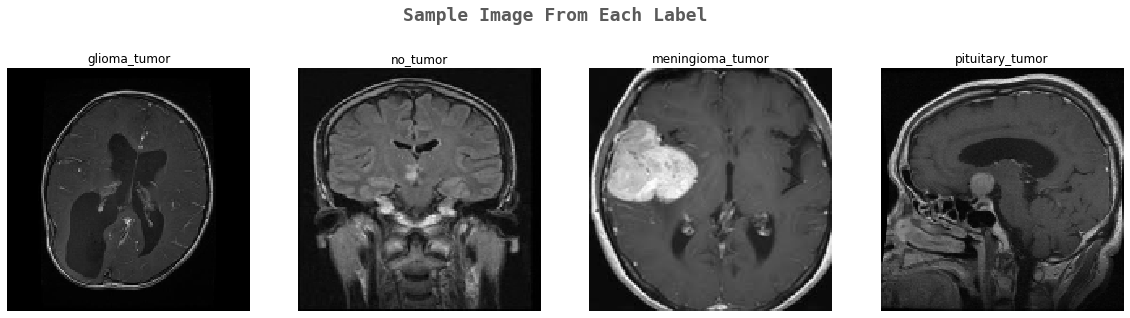

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, X_test, y_train, y_test = train_test_split (X_train, y_train, test_size=0.1)

In [7]:
# One-hot encode outputs
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
X_train.shape[1:]

(150, 150, 3)

In [9]:
y_train[1:]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

**Augmenting The Data**

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2)

aug.fit(X_train)
aug.fit(X_test)

In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [12]:
model = effnet.output
model = Flatten()(model)
model = Dense(1024,activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(4,activation='softmax')(model)
model = Model(inputs=effnet.input,outputs=model)

**MODEL**

In [13]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
model.fit(aug.flow(X_train,y_train,batch_size=32),epochs=10,validation_data=aug.flow(X_test,y_test))

Epoch 1/10
92/92 [==============================] - 162s 2s/step - loss: 1.4950 - accuracy: 0.7283 - val_loss: 0.9153 - val_accuracy: 0.7309
Epoch 2/10
92/92 [==============================] - 165s 2s/step - loss: 0.4110 - accuracy: 0.8645 - val_loss: 0.7879 - val_accuracy: 0.6758
Epoch 3/10
92/92 [==============================] - 166s 2s/step - loss: 0.3183 - accuracy: 0.8907 - val_loss: 2.1121 - val_accuracy: 0.5810
Epoch 4/10
92/92 [==============================] - 166s 2s/step - loss: 0.3348 - accuracy: 0.8938 - val_loss: 0.6255 - val_accuracy: 0.8257
Epoch 5/10
92/92 [==============================] - 165s 2s/step - loss: 0.2927 - accuracy: 0.8999 - val_loss: 0.3129 - val_accuracy: 0.8746
Epoch 6/10
92/92 [==============================] - 165s 2s/step - loss: 0.2525 - accuracy: 0.9200 - val_loss: 0.8519 - val_accuracy: 0.8532
Epoch 7/10
92/92 [==============================] - 166s 2s/step - loss: 0.3319 - accuracy: 0.8938 - val_loss: 0.7200 - val_accuracy: 0.8563
Epoch 8/10
92

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
new_y = np.argmax(y_test,axis=1)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(new_y,pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        86
           1       0.83      1.00      0.91        53
           2       1.00      0.70      0.82        93
           3       0.90      1.00      0.95        95

    accuracy                           0.89       327
   macro avg       0.90      0.90      0.89       327
weighted avg       0.90      0.89      0.89       327



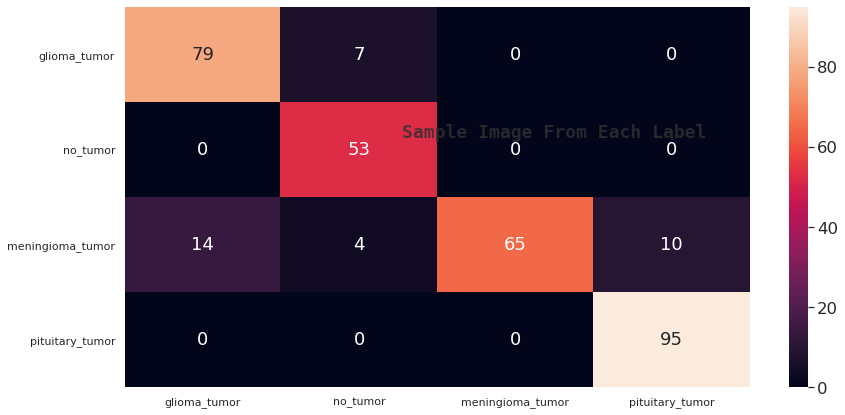

In [27]:
fig, ax = plt.subplots(1,1,figsize=(14,7))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(new_y,pred),annot=True,xticklabels=labels,yticklabels=labels)
sns.set(font_scale=1)
plt.show()